In [42]:
%matplotlib inline
import numpy as np
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import pandas as pd
# import auquanToolbox.dataloader as dl
import yfinance as yf
from pandas_datareader import data as pdr
import datetime as dt
import mplfinance as mpf


from statsmodels.tsa.arima.model import ARIMA
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.tsa.stattools as smts 
import statsmodels.api as sm
import scipy.stats as scs

from sklearn.metrics import mean_squared_error
yf.pdr_override()



In [12]:
def tsa_plots(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()

def run_adf_test(series, alpha=0.05):
    res = smts.adfuller(series)
#     print(res)
    print("ADF Statistic: %f" % res[0])
    print("p value: %f" % res[1])
    if res[1] < 0.05:
        print("Series IS stationary!")
    else:
        print("Series IS NOT stationary!")
        

In [13]:
stock='SPY'
### Training data
start_train = "2014-01-01"
end_train = "2016-12-31"
train = yf.download(stock, start_train, end_train, interval='1d')
train.head()

### Testing data
start_test = "2017-01-01"
end_test = "2020-09-30"

test = yf.download(stock,start_test, end_test, interval='1d')
test.head()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,225.039993,225.830002,223.880005,225.240005,209.785889,91366500
2017-01-04,225.619995,226.750000,225.610001,226.580002,211.033981,78744400
2017-01-05,226.270004,226.580002,225.479996,226.399994,210.866318,78379000
2017-01-06,226.529999,227.750000,225.899994,227.210007,211.620728,71559900
2017-01-09,226.910004,227.070007,226.419998,226.460007,210.922211,46939700


In [58]:
run_adf_test(np.diff(train["Close"]))
## can work with this

ADF Statistic: -27.604719
p value: 0.000000
Series IS stationary!


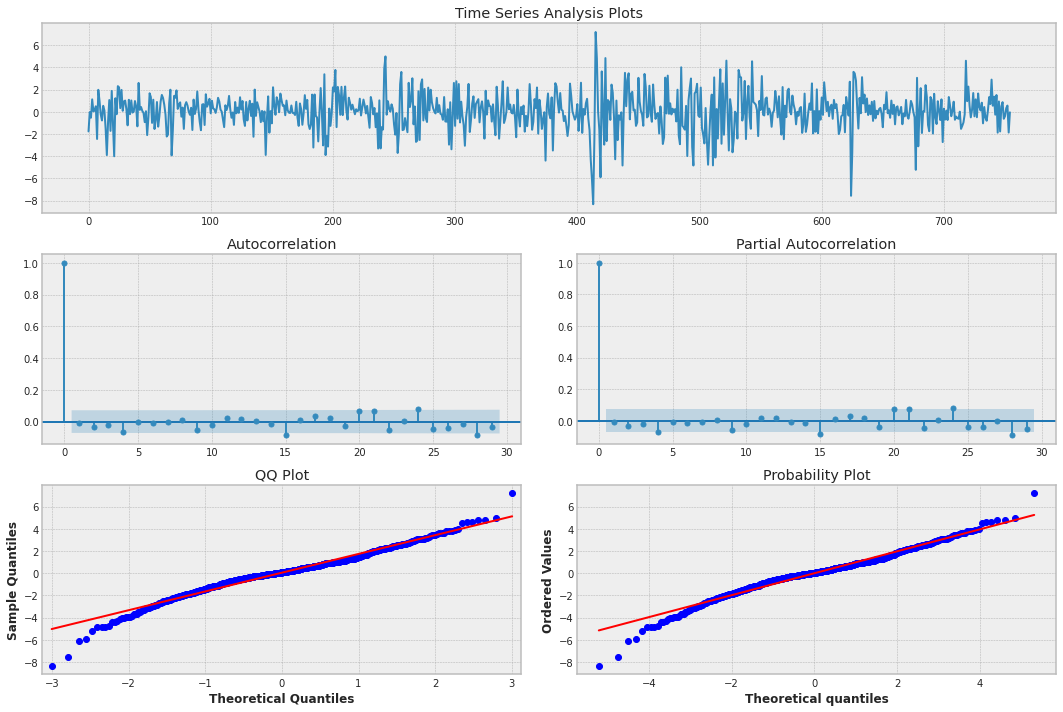

In [59]:
tsa_plots(np.diff(train["Close"]))

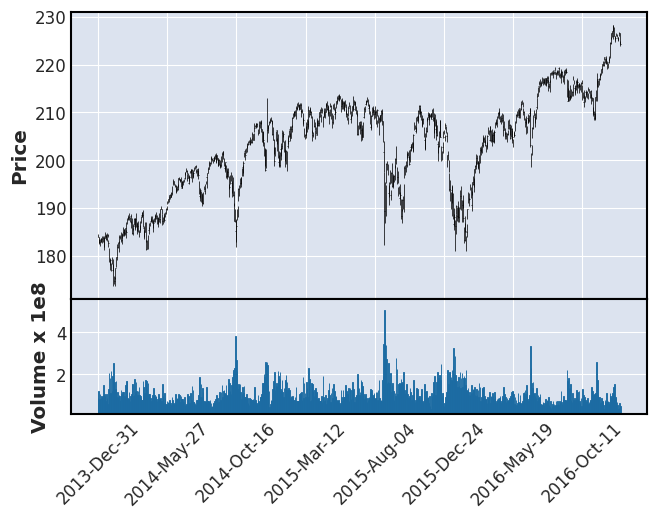

In [15]:
mpf.plot(train, volume = True)

942


Date
2017-01-03    225.240005
2017-01-04    226.580002
2017-01-05    226.399994
2017-01-06    227.210007
2017-01-09    226.460007
                 ...    
2020-09-23    322.640015
2020-09-24    323.500000
2020-09-25    328.730011
2020-09-28    334.190002
2020-09-29    332.369995
Name: Close, Length: 942, dtype: float64

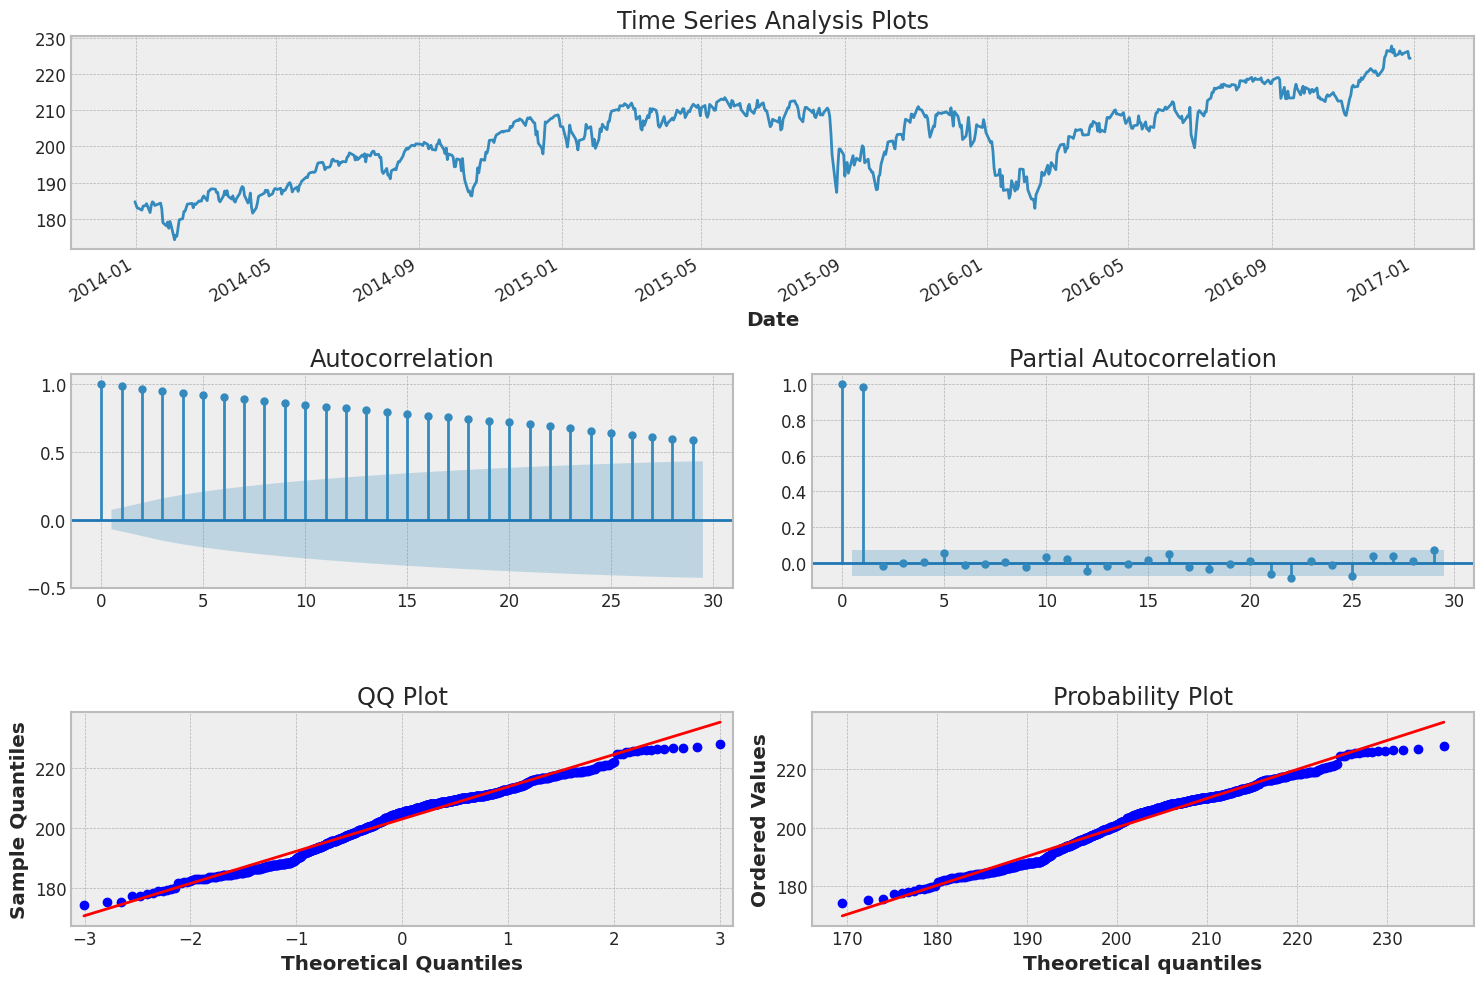

In [16]:
# tsa_plots(np.diff(train["Close"]))
tsa_plots(train["Close"])
print(len(test["Close"]))
test["Close"]




In [53]:
## generating and testing ARIMA model

history = [x for x in train["Close"]]
predictions = []

#
for i in range(0, len(test["Close"])):
    if (i % 50) == 0:
        print(i, "iteration out of", len(test["Close"]))
    model = ARIMA(history, order=(1, 1, 3))
    fitted_model = model.fit()
    output = fitted_model.forecast()
    pred_price = output[0]
    predictions.append(pred_price)
    actual_price = test["Close"][i]
    history.append(actual_price)
                

        
                  

0 iteration out of 942
50 iteration out of 942
100 iteration out of 942
150 iteration out of 942
200 iteration out of 942
250 iteration out of 942
300 iteration out of 942
350 iteration out of 942
400 iteration out of 942
450 iteration out of 942
500 iteration out of 942
550 iteration out of 942
600 iteration out of 942
650 iteration out of 942
700 iteration out of 942
750 iteration out of 942
800 iteration out of 942


/home/rhizi/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/rhizi/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


850 iteration out of 942
900 iteration out of 942


MSE: 12.0107


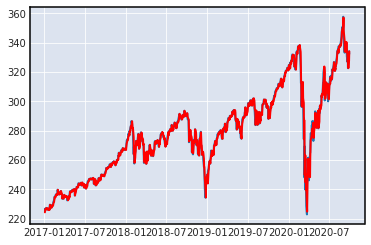

In [54]:
mse = mean_squared_error(test["Close"], predictions)
print("MSE: %.4f" % mse)
plt.plot(test["Close"])
plt.plot(test["Close"].index, predictions, color = 'red')
plt.show()

In [57]:
fitted_model.forecast(50, alpha = 0.05)

array([334.13763983, 335.00692477, 334.79467459, 334.68750973,
       334.63340232, 334.60608356, 334.59229035, 334.58532617,
       334.58180997, 334.58003464, 334.57913828, 334.57868571,
       334.57845721, 334.57834184, 334.57828359, 334.57825417,
       334.57823933, 334.57823183, 334.57822804, 334.57822613,
       334.57822517, 334.57822468, 334.57822443, 334.57822431,
       334.57822425, 334.57822421, 334.5782242 , 334.57822419,
       334.57822419, 334.57822418, 334.57822418, 334.57822418,
       334.57822418, 334.57822418, 334.57822418, 334.57822418,
       334.57822418, 334.57822418, 334.57822418, 334.57822418,
       334.57822418, 334.57822418, 334.57822418, 334.57822418,
       334.57822418, 334.57822418, 334.57822418, 334.57822418,
       334.57822418, 334.57822418])

In [29]:

print(test)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2017-01-03  225.039993  225.830002  223.880005  225.240005  209.785889   
2017-01-04  225.619995  226.750000  225.610001  226.580002  211.033981   
2017-01-05  226.270004  226.580002  225.479996  226.399994  210.866318   
2017-01-06  226.529999  227.750000  225.899994  227.210007  211.620728   
2017-01-09  226.910004  227.070007  226.419998  226.460007  210.922211   
...                ...         ...         ...         ...         ...   
2020-09-23  330.899994  331.200012  322.100006  322.640015  322.640015   
2020-09-24  321.220001  326.799988  319.799988  323.500000  323.500000   
2020-09-25  322.579987  329.579987  321.640015  328.730011  328.730011   
2020-09-28  333.220001  334.959991  332.149994  334.190002  334.190002   
2020-09-29  333.970001  334.769989  331.619995  332.369995  332.369995   

              Volume  
Date          

/home/rhizi/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/rhizi/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/rhizi/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  756
Model:                 ARIMA(1, 1, 7)   Log Likelihood               -1464.611
Date:                Fri, 16 Oct 2020   AIC                           2947.222
Time:                        22:30:14   BIC                           2988.863
Sample:                             0   HQIC                          2963.262
                                - 756                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9603      0.053     18.143      0.000       0.857       1.064
ma.L1         -0.9705      0.060    -16.201      0.000      -1.088      -0.853
ma.L2         -0.0262      0.041     -0.642      0.5

/home/rhizi/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


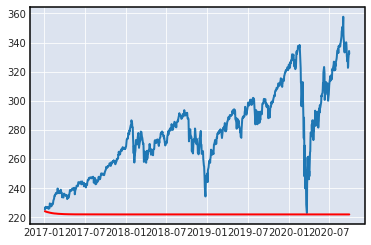

3952.305199005195


In [51]:
model = ARIMA(train["Close"], order=(1, 1, 7))
fitted_model = model.fit()
print(fitted_model.summary())

start_index = len(train["Close"]) + 1
end_index = len(train["Close"]) + len(test["Close"])
preds = fitted_model.predict(start = start_index, end= end_index)
print(preds)
mse = mean_squared_error(test["Close"], preds)

plt.plot(test["Close"])
plt.plot(test["Close"].index, preds, color = 'red')
plt.show()

print(mse)

# fitted_model.plot_predict(start = 0, end=900)
# plt.show()
